In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import List, Tuple
%matplotlib inline

In [7]:
words = open("names.txt").read().splitlines()

In [8]:
len(words)

32033

In [9]:
chars = sorted(list(set(''.join(words))))
# encoding and decoding chars
stoi = {ch: i + 1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(stoi)

In [10]:
# hyperparameters
learning_rate = 0.01
max_epochs = 200000
batch_size = 32
n_embd = 10 # aka C
block_size = 3

In [11]:
# build dataset
def build_dataset (words: List[str]) -> Tuple[torch.Tensor, torch.Tensor]:
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)

import random
random.seed(42)
random.shuffle(words)

# make training, validation and test splits
n1, n2 = int(len(words) * 0.8), int(len(words) * 0.9)
X_train, Y_train = build_dataset(words[:n1])
X_valid, Y_valid = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [12]:
# first layer
n_hidden = 200
g = torch.Generator().manual_seed(42)
token_embedding_table = torch.randn(vocab_size, n_embd, generator=g)
W1 = torch.randn(n_embd * block_size, n_hidden, generator=g)
b1 = torch.randn(n_hidden, generator=g)

# output layer
W2 = torch.randn(n_hidden, vocab_size, generator=g) * 0.01 # we want small weights
b2 = torch.zeros(vocab_size, generator=g)
parameters = [token_embedding_table, W1, b1, W2, b2]

In [13]:
for param in parameters:
    param.requires_grad_()

In [14]:
stepi = []
lossi = []

In [15]:
for i in range(max_epochs):
    # construct minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    tok_emb = token_embedding_table[Xb] # T x block_size x C
    emb_cat = tok_emb.view(-1, block_size * n_embd) # T x (block_size * C)
    h_preact =  emb_cat @ W1 + b1
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) 
    
    if i % 10000 == 0:
        print(f'Step {i:7d} Loss: {loss:.4f}')

    # backward pass
    for p in parameters: # zero out the gradients
        p.grad = None
    loss.backward()

    # update parameters
    lr = learning_rate if i < max_epochs / 2 else learning_rate / 10
    for p in parameters:
        p.data += -lr * p.grad
    
    stepi.append(i)
    lossi.append(loss.log10().item())


Loss: 31.8885
Loss: 3.3514
Loss: 2.2771
Loss: 2.3091
Loss: 2.1673
Loss: 2.5074
Loss: 2.2046
Loss: 2.0713
Loss: 2.7478
Loss: 1.9985
Loss: 2.4598
Loss: 2.5528
Loss: 2.0847
Loss: 2.4481
Loss: 1.8782
Loss: 1.9402
Loss: 2.5021
Loss: 2.5068
Loss: 2.4469
Loss: 2.0308


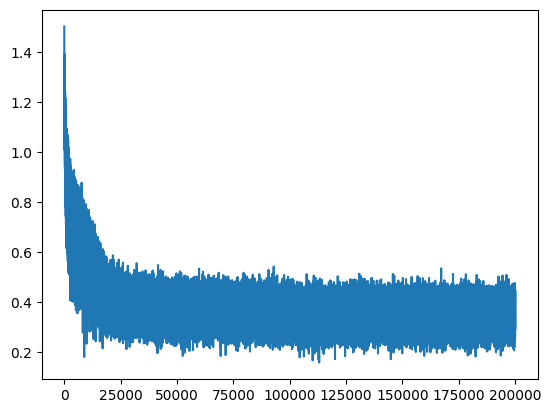

In [21]:
plt.plot(stepi, lossi)

In [23]:
@torch.no_grad()
def split_loss (split: str) -> float:
    x, y = {
        'train': (X_train, Y_train),
        'valid': (X_valid, Y_valid),
        'test': (X_test, Y_test)
    }[split]

    # evaluate loss on validation set
    tok_emb = token_embedding_table[x] # T x block_size x C
    h = torch.tanh(tok_emb.view(-1, n_embd * block_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y) 
    return split, loss.item()

print (split_loss('train'))
print (split_loss('valid'))

('train', 2.2602012157440186)
('valid', 2.267983913421631)


In [24]:
print (split_loss('test'))

('test', 2.261622667312622)


In [20]:
# generate some names
g = torch.Generator().manual_seed(42)
for i in range(20):
    out = []
    context = [0] * block_size
    while True:
        tok_emb = token_embedding_table[torch.tensor([context])]
        h = torch.tanh(tok_emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix) 
        if itos[ix] == '.':
            break
    print(''.join(itos[i] for i in out))

anuheen.
tis.
mabian.
dante.
nalielayley.
kemah.
laman.
eamariolen.
diza.
kence.
jordon.
kalla.
mikh.
yana.
cveria.
aceella.
tian.
tuyja.
mar.
tal.
